**Introduzione** \\


L'obiettivo di questo progetto è quello di costruire un modello di Deep Learning per un problema di classificazione multilabel sbilanciato. Vista la natura del contesto, verrà considerata la recall come misura da ottimizzare al fine di minimizzare i falsi negativi. \
Dopo una prima fase di preprocessing e tokenizzazione, viene costruito un modello di Deep Learning in cui vengono addestrate separatamente 6 reti neurali, una per ogni colonna di target. In questo modo si può addestrare ognuna delle 6 reti per un problema di classificazione binario. \
Vedremo i dettagli del modello più avanti.

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, InputLayer,SimpleRNN, GRU
from keras.metrics import Recall
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import save_model, load_model

In [33]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [35]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [36]:
df.shape

(159571, 8)

In [37]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


Controlliamo se ci sono valori mancanti nel dataframe.

In [38]:
df.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64

Le due celle seguenti servono per dare un'idea dello sbilanciamento delle classi.

In [39]:
conteggi_per_classe = {}
for name in df.columns:
  if name == 'comment_text' or name == 'sum_injurious':
        continue
  conteggi = df[name].value_counts()
  conteggi_per_classe[name] = conteggi

tabella_conteggi = pd.DataFrame(conteggi_per_classe)
print(tabella_conteggi)

    toxic  severe_toxic  obscene  threat  insult  identity_hate
0  144277        157976   151122  159093  151694         158166
1   15294          1595     8449     478    7877           1405


In [40]:
df['sum_injurious'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: sum_injurious, dtype: int64

**Preprocessing del testo**

In questa sezione viene normalizzato il testo con questi passaggi:\
1) si riporta il testo in minuscolo e si sostituisce il carattere "\n" con uno spazio;\
2) si sostituiscono i caratteri non alfanumerici con uno spazio;\
3) si rimuovono le stopwords che sono le parole più comuni nell'insieme delle parole inglesi, che non danno un contributo al contesto semantico della frase;\
4) si rimuovono i caratteri numerici che non sembrano informativi visto il contesto;\
5) si rimuovono gli spazi vuoti lasciati dalle operazioni fatte nei punti precedenti.



Prendiamo un esempio di frase grezza e vediamo come si trasforma seguendo i punti descritti.

In [41]:
df.loc[1,'comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

Nel seguito vengono inseriti i 5 punti descritti sopra in 5 funzioni all'interno di una classe. L'ultima funzione della classe esegue tutte le funzioni del preprocessing.

In [42]:
class text_preprocessing():

    def to_lower_remove_newline(df_text):
        return [frase.lower().replace('\n', '') for frase in df_text]


    def non_alfanum_remove(df_text):
        return [re.sub(r'[^\w\s]', ' ', frase) for frase in df_text]

    def stopwords_remove(df_text):

        stop_words = set(stopwords.words('english'))

        text_preprocessed = []
        rem_stop = []

        for frase in df_text:
            rem_stop.append( [word for word in frase.split() if word not in stop_words] )

        for j in range(0, len(rem_stop)):
            text_preprocessed.append(' '.join(rem_stop[j]))
        return text_preprocessed

    def num_remove(df_text):
        return [re.sub(r'\d+', '', frase) for frase in df_text]

    def space_remove(df_text):
        return [re.sub(r'\s+', ' ', frase) for frase in df_text]

    def preprocess(df_text):
        df_text = text_preprocessing.to_lower_remove_newline(df_text)
        df_text = text_preprocessing.non_alfanum_remove(df_text)
        df_text = text_preprocessing.stopwords_remove(df_text)
        df_text = text_preprocessing.num_remove(df_text)
        df_text = text_preprocessing.space_remove(df_text)
        return df_text

In [43]:
text_preprocessed = text_preprocessing.preprocess(df['comment_text'])

In [44]:
text_preprocessed[1]

'aww matches background colour seemingly stuck thanks talk january utc'

**Costruzione delle sequenze**

In questa sezione viene eseguita la tokenizzazione del testo ottenuto nella sezione precedente, poi viene eseguito il padding per riportare la lunghezza di tutte le stringhe alla lunghezza della stringa più lunga. \


In [45]:
Y = df[['toxic', 'severe_toxic', 'obscene',	'threat',	'insult',	'identity_hate']].values


X_train, X_test, Y_train, Y_test = train_test_split(text_preprocessed, Y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [46]:
vocabulary_size = len(tokenizer.word_index)+1

In [47]:
maxlen = len(max(X_train_token,key=len))
maxlen

1250

In [48]:
padded_train = pad_sequences(X_train_token, maxlen=maxlen)
padded_test = pad_sequences(X_test_token, maxlen=maxlen)

**Costruzione del modello** \
Come anticipato nell'introduzione, verrà costruito un modello di classificazione binario per ogni colonna di label.\
Innanzitutto si costruisce un modello sequenziale con una rete LSTM e ultimo layer fully connected con un neurone e funzione di attivazione sigmoide. \
Poi, la classe che utilizzeremo per le previsioni estende la classe Sequential di keras, sovrascrivendo le funzioni fit e predict. \
Infatti nel modello si addestra separatemente una rete (definita prima) per ogni classe. Per ottimizzare le prestazioni, visto che le classi possono essere correlate, ad ogni iterazione successiva alla prima vengono inizializzati i pesi ai pesi del modello addestrato sulla classe precedente. In fase di addestramento viene gestito lo sbilanciamento tra classi con l'undersampling, in questo modo si ottimizza anche il tempo di esecuzione. \
Nel predict, viene restituita per ogni osservazione un vettore di 6 entrate in cui viene predetta la classe positiva se l'output del modello (la probabilità di appartenenza alla classe positiva) supera 0.3, anche in questo caso la scelta viene fatta per massimizzare la recall visto lo sbilanciamento tra classi.


In [49]:
def get_lstm():
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=maxlen))
  model.add(LSTM(64, activation = 'tanh'))
  model.add(Dense(1, activation = 'sigmoid'))
  return model

Decidiamo di fermare il training quando alla fine di un'epoca la recall sul validation set supera 0.9.

In [50]:
class callback_early_stopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_recall'] >= 0.9:
            print("\nValidation accuracy above 0.9, stopping training.\n")
            self.model.stop_training = True

In [51]:
mycb = callback_early_stopping()

Di seguito un dizionario di comidità.

In [52]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classes_dict = {i: category for i, category in enumerate(classes)}

Definiamo ora il modello.

In [53]:
class MultiLabelModel(Sequential):
  def fit(self, X_train, Y_train, **kwargs):
    self.models = []
    self.hist = []

    for i in range(0,6):
        print(f'\n Training for class {classes_dict[i]}\n')
        clear_session()
        model = get_lstm()
        model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics = [Recall()])

        if i > 0:
            model.set_weights(self.models[i - 1].get_weights())

        rus = RandomUnderSampler(random_state=42)

        X_train_resampled, Y_train_resampled = rus.fit_resample(X_train, Y_train[:,i])

        self.hist.append( model.fit(X_train_resampled, Y_train_resampled , validation_split=.2 , epochs=3, verbose=1, batch_size = 256, callbacks = [mycb]) )

        self.models.append(model)


  def predict(self, X_test):
      predictions = []
      for model in self.models:
          predictions.append((model.predict(X_test) > 0.3).astype(int))
      return np.array(predictions).T

In [54]:
hater_rec_model = MultiLabelModel()

In [55]:
hater_fit = hater_rec_model.fit(padded_train, Y_train)


 Training for class toxic

Epoch 1/3
77/77 [==============================] - 369s 5s/step - loss: 0.5266 - recall: 0.4586 - val_loss: 0.5235 - val_recall: 0.7429
Epoch 2/3
77/77 [==============================] - 365s 5s/step - loss: 0.3131 - recall: 0.7825 - val_loss: 0.4240 - val_recall: 0.7904
Epoch 3/3
77/77 [==============================] - 372s 5s/step - loss: 0.2461 - recall: 0.8310 - val_loss: 0.3798 - val_recall: 0.8395

 Training for class severe_toxic

Epoch 1/3
8/8 [==============================] - ETA: 0s - loss: 0.2123 - recall: 0.9450
Validation accuracy above 0.9, stopping training.

8/8 [==============================] - 41s 5s/step - loss: 0.2123 - recall: 0.9450 - val_loss: 0.1534 - val_recall: 0.9451

 Training for class obscene

Epoch 1/3
43/43 [==============================] - ETA: 0s - loss: 0.2253 - recall: 0.8837
Validation accuracy above 0.9, stopping training.

43/43 [==============================] - 203s 5s/step - loss: 0.2253 - recall: 0.8837 - val_lo

Mostriamo l'andamento della loss e della recall sul train set e sul validation set nelle varie epoche per ogni classe. Visto che per due classi il training si è fermato dopo un'epoca visto che ha raggiunto una validation recall superiore a 0.9, per queste due classi mostriamo uno scatter plot.

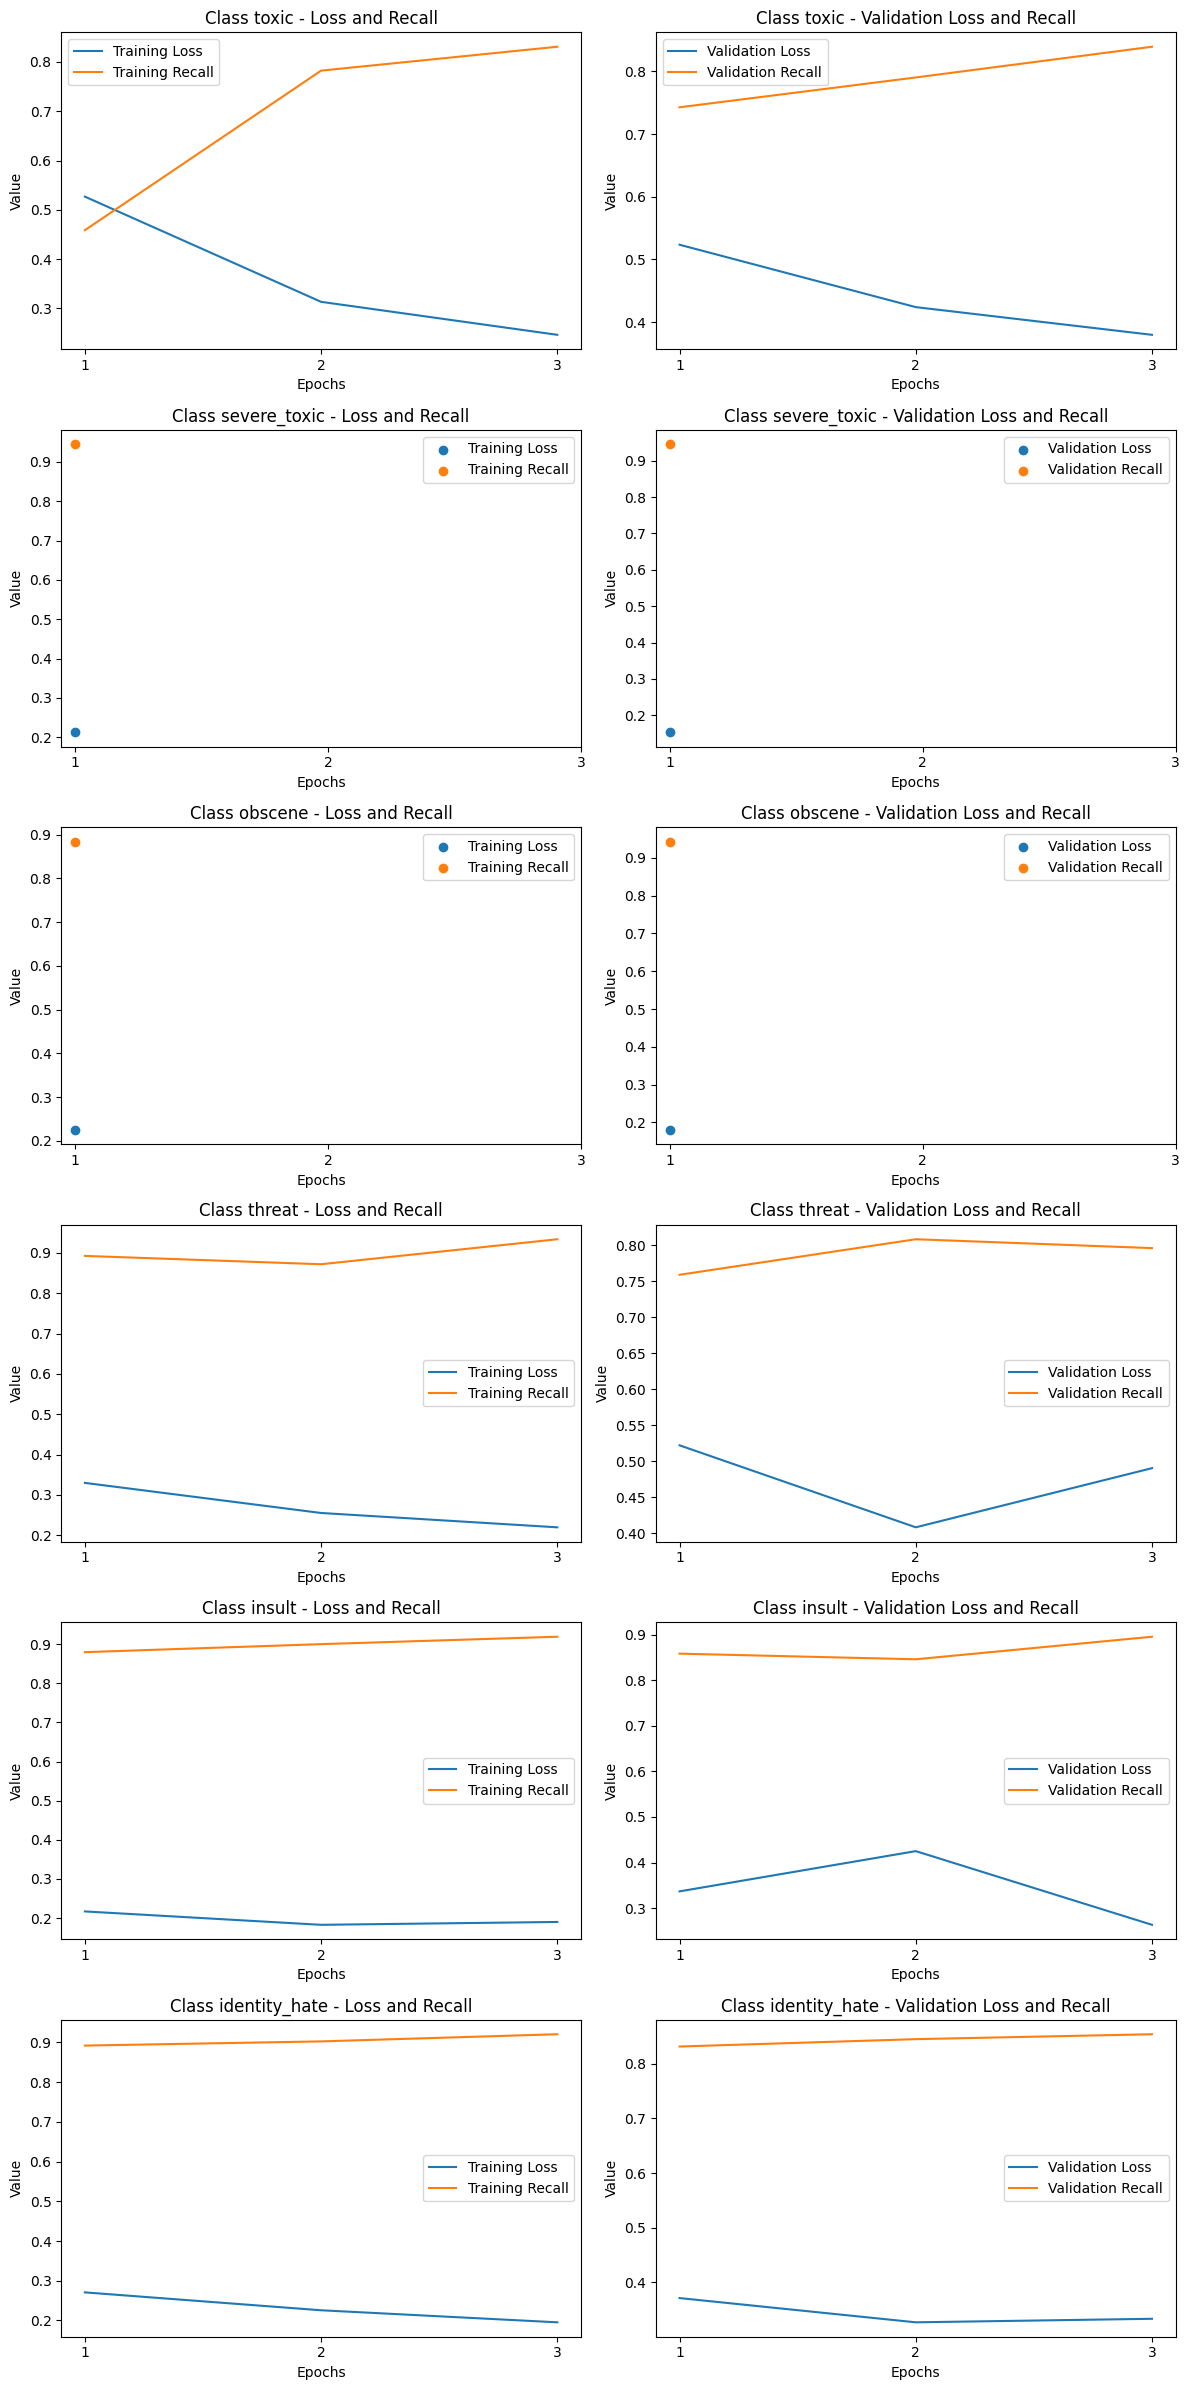

In [101]:
history = hater_rec_model.hist
fig, axes = plt.subplots(6, 2, figsize=(12, 24))

for i in range(6):
    num_epochs = len(history[i].history['loss'])
    if num_epochs == 1:
      axes[i, 0].scatter(np.arange(1,num_epochs+1), history[i].history['loss'], label='Training Loss')
      axes[i, 0].scatter(np.arange(1,num_epochs+1), history[i].history['recall'], label='Training Recall')
      axes[i, 0].set_title(f'Class {classes_dict[i]} - Loss and Recall')
      axes[i, 0].set_xticks(range(1, 4))
      axes[i, 0].set_xlabel('Epochs')
      axes[i, 0].set_ylabel('Value')
      axes[i, 0].legend()

      axes[i, 1].scatter(np.arange(1,num_epochs+1), history[i].history['val_loss'], label='Validation Loss')
      axes[i, 1].scatter(np.arange(1,num_epochs+1), history[i].history['val_recall'], label='Validation Recall')
      axes[i, 1].set_title(f'Class {classes_dict[i]} - Validation Loss and Recall')
      axes[i, 1].set_xticks(range(1, 4))
      axes[i, 1].set_xlabel('Epochs')
      axes[i, 1].set_ylabel('Value')
      axes[i, 1].legend()

    else:

      axes[i, 0].plot(np.arange(1,num_epochs+1), history[i].history['loss'], label='Training Loss')
      axes[i, 0].plot(np.arange(1,num_epochs+1), history[i].history['recall'], label='Training Recall')
      axes[i, 0].set_title(f'Class {classes_dict[i]} - Loss and Recall')
      axes[i, 0].set_xticks(range(1, 4))
      axes[i, 0].set_xlabel('Epochs')
      axes[i, 0].set_ylabel('Value')
      axes[i, 0].legend()


      axes[i, 1].plot(np.arange(1,num_epochs+1), history[i].history['val_loss'], label='Validation Loss')
      axes[i, 1].plot(np.arange(1,num_epochs+1), history[i].history['val_recall'], label='Validation Recall')
      axes[i, 1].set_title(f'Class {classes_dict[i]} - Validation Loss and Recall')
      axes[i, 1].set_xticks(range(1, 4))
      axes[i, 1].set_xlabel('Epochs')
      axes[i, 1].set_ylabel('Value')
      axes[i, 1].legend()

plt.tight_layout()
plt.show()

Valutiamo ora il modello sul set di test.

In [56]:
predictions = hater_rec_model.predict(padded_test)

998/998 [==============================] - 176s 176ms/step


Con la seguente funzione valutiamo la recall con media pesata sulle sei classi e la accuracy complessiva del modello.

In [61]:
def evaluate_model(y_true, y_pred):
    print(f"Recall weighted: {recall_score(y_true, y_pred, average = 'weighted' ):.3f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")

In [62]:
evaluate_model(Y_test, predictions[0])

Recall weighted: 0.925
Accuracy: 0.726


Con la seguente funzione vediamo la recall per ogni classe.

In [102]:
def evaluate_recall_per_class():
    recalls = []
    for i in range(0,6):
        recall = recall_score(Y_test[:, i], predictions[0].T[i])
        recalls.append(recall)
        print(f'Recall for class {classes_dict[i]}: {recall:.3f}')

In [103]:
evaluate_recall_per_class()

Recall for class toxic: 0.900
Recall for class severe_toxic: 0.953
Recall for class obscene: 0.966
Recall for class threat: 0.878
Recall for class insult: 0.930
Recall for class identity_hate: 0.901
